In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116951 sha256=82c7b51b765f305f2a7180615358cf1102cbf61db735f839186913ca7e7e75cd
  Stored in directory: /root/.cache/pip/wheels/20/97/e1/dd2c472bebcdcaa85fdc07d0f19020299f1c86773028860c53
Successfully built fire


In [2]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *

In [3]:
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [4]:
DataClass=getattr(medmnist, info['python_class'])

In [17]:
import torchvision.transforms as T

transform = T.Resize(224)

In [5]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [6]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [7]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [8]:
train_df=pd.DataFrame.from_dict(data)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,0,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,False
108305,<PIL.Image.Image image mode=L size=28x28>,3,False
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,0,False


In [9]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,3,True
1,<PIL.Image.Image image mode=L size=28x28>,0,False
2,<PIL.Image.Image image mode=L size=28x28>,0,False
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,3,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,True
108305,<PIL.Image.Image image mode=L size=28x28>,0,True
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,3,False


In [18]:

def get_x(r):
    img=transform(r['Image'])
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [19]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) 
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

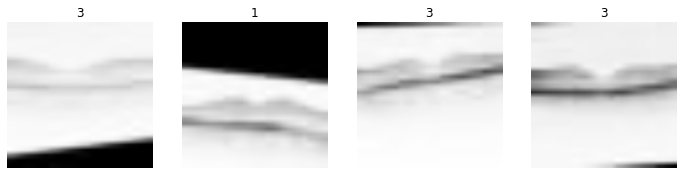

In [20]:
dls = dblock.dataloaders(train_df, bs=32, device=torch.device('cuda'))
dls.show_batch(nrows=1, ncols=4)

In [21]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

In [22]:
learn.fine_tune(8, base_lr=3e-3, freeze_epochs=2)  

epoch,train_loss,valid_loss,accuracy,time
0,1.062159,0.727309,0.749018,02:43
1,0.688626,0.575090,0.807113,02:43


epoch,train_loss,valid_loss,accuracy,time
0,0.441838,0.409362,0.855402,02:48
1,0.411704,0.430907,0.858141,02:50
2,0.390349,0.407966,0.867435,02:49
3,0.252209,0.387823,0.885358,02:50
4,0.155022,0.403516,0.884475,02:49
5,0.054670,0.468330,0.890641,02:49
6,0.025170,0.510040,0.893729,02:48
7,0.012227,0.491434,0.892980,02:47


In [26]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [0.4914340674877167,0.8929798603057861]

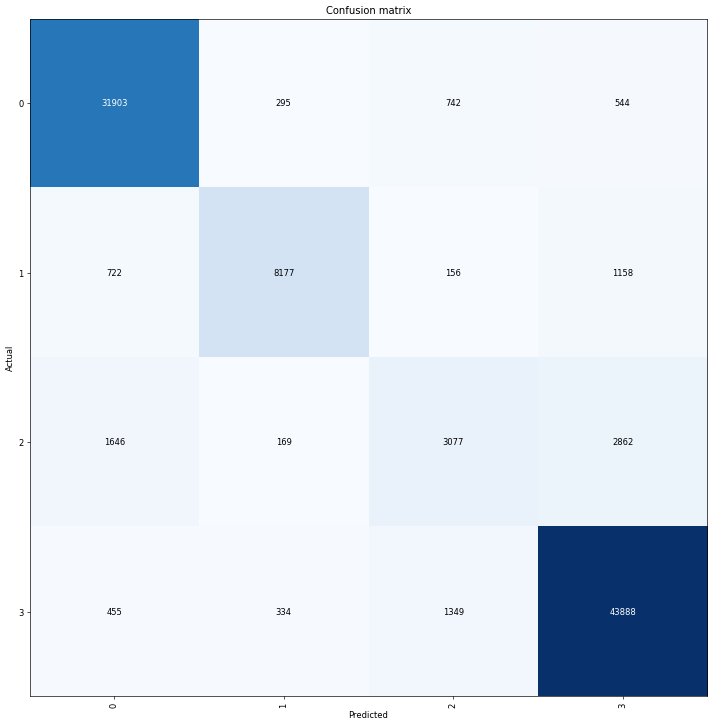

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [28]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(transform(test_dataset[i][0]))
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [29]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.54      0.99      0.70       250
           1       0.97      0.66      0.79       250
           2       0.93      0.16      0.27       250
           3       0.71      0.94      0.81       250

    accuracy                           0.69      1000
   macro avg       0.79      0.69      0.64      1000
weighted avg       0.79      0.69      0.64      1000

